In [22]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import string
import nltk
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [23]:
df = pd.read_csv('train.csv')
df


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


In [24]:
stopwords = nltk.corpus.stopwords.words("english")
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()

In [25]:
def preprocess(tweet):  
    
    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ')

    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '')

    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '')
    
    # removal of punctuations and numbers
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
    # remove whitespace with a single space
    newtweet=punc_remove.str.replace(r'\s+', ' ')
    # remove leading and trailing whitespace
    newtweet=newtweet.str.replace(r'^\s+|\s+?$','')
    # replace normal numbers with numbr
    newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')
    # removal of capitalization
    tweet_lower = newtweet.str.lower()
    
    # tokenizing
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())
    
    # removal of stopwords
    tokenized_tweet=  tokenized_tweet.apply(lambda x: [item for item in x if item not in stopwords])
    
    # stemming of the tweets
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
    
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p= tokenized_tweet
    
    return tweets_p

In [26]:
tweet=df.tweet
processed_tweets = preprocess(tweet)
print(processed_tweets)

0            father dysfunct selfish drag kid dysfunct run
1        thank lyft credit use caus offer wheelchair va...
2                                           bihday majesti
3                              model love u take u time ur
4                                  factsguid societi motiv
                               ...                        
31957                                        ate isz youuu
31958    see nina turner airwav tri wrap mantl genuin h...
31959             listen sad song monday morn otw work sad
31960          sikh templ vandalis calgari wso condemn act
31961                                         thank follow
Name: tweet, Length: 31962, dtype: object


In [27]:
df['processed_tweets'] = processed_tweets

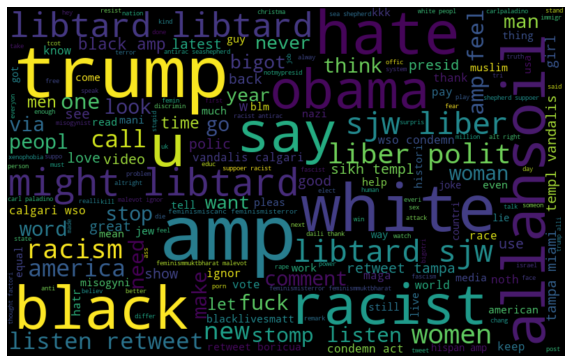

In [28]:
from wordcloud import WordCloud
hatred_words = ' '.join([text for text in df['processed_tweets'][df['label'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(hatred_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(df['processed_tweets'] )
tfidf

<31962x8244 sparse matrix of type '<class 'numpy.float64'>'
	with 237809 stored elements in Compressed Sparse Row format>

In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
X = tfidf
y = df['label'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
model = LogisticRegression().fit(X_train_tfidf,y_train)
y_preds = model.predict(X_test_tfidf)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5937
           1       0.91      0.35      0.50       456

    accuracy                           0.95      6393
   macro avg       0.93      0.67      0.74      6393
weighted avg       0.95      0.95      0.94      6393

Logistic Regression, Accuracy Score: 0.9510402002189895


In [30]:
from sklearn.ensemble import RandomForestClassifier
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train_tfidf,y_train)
y_preds = rf.predict(X_test_tfidf)
acc1=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Random Forest, Accuracy Score:",acc1)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5937
           1       0.84      0.57      0.68       456

    accuracy                           0.96      6393
   macro avg       0.90      0.78      0.83      6393
weighted avg       0.96      0.96      0.96      6393

Random Forest, Accuracy Score: 0.9613639918661036


In [31]:
from sklearn.naive_bayes import GaussianNB
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X.toarray(), y, random_state=42, test_size=0.2)
nb=GaussianNB()
nb.fit(X_train_tfidf,y_train)
y_preds = nb.predict(X_test_tfidf)
acc2=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Naive Bayes, Accuracy Score:",acc2)

              precision    recall  f1-score   support

           0       0.97      0.86      0.91      5937
           1       0.27      0.69      0.39       456

    accuracy                           0.85      6393
   macro avg       0.62      0.77      0.65      6393
weighted avg       0.92      0.85      0.88      6393

Naive Bayes, Accuracy Score: 0.8470201783200375
